In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ttcrpy.rgrid import Grid2d

plt.style.use('seaborn')

# Inversion linéaire - Résolution

On utilise un exemple de tomographie pour illustrer le concept de résolution des paramètres.

On défini un modèle comportant $M$ = 16 paramètres

$N$ = 10 mesures sont réalisées

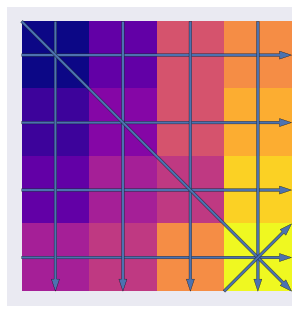

In [2]:
mtrue = np.array([1.0, 1.1, 1.2, 1.4,
                  1.2, 1.3, 1.4, 1.5,
                  1.6, 1.6, 1.5, 1.8,
                  1.8, 1.9, 2.0, 2.1])

h = 2

nx = 4
nz = 4

Tx = h*np.array([[0.0, 0.5],
                 [0.0, 1.5],
                 [0.0, 2.5],
                 [0.0, 3.5],
                 [0.5, 0.0],
                 [1.5, 0.0],
                 [2.5, 0.0],
                 [3.5, 0.0],
                 [0.0, 0.0],
                 [3.0, 4.0]])
Rx = h*np.array([[4.0, 0.5],
                 [4.0, 1.5],
                 [4.0, 2.5],
                 [4.0, 3.5],
                 [0.5, 4.0],
                 [1.5, 4.0],
                 [2.5, 4.0],
                 [3.5, 4.0],
                 [4.0, 4.0],
                 [4.0, 3.0]])

# coordonnées pour l'affichage des trajectoires des rais
Tx2 = Tx/h-0.5
Rx2 = Rx/h-0.5

plt.imshow(mtrue.reshape(nx, nz).T, cmap='plasma')
plt.grid()
for n in range(Tx2.shape[0]):
    plt.arrow(Tx2[n, 0], Tx2[n, 1], Rx2[n, 0]-Tx2[n,0], Rx2[n, 1]-Tx2[n,1],
              width=0.04, length_includes_head=True)
plt.gca().set_xticklabels('')
plt.gca().set_yticklabels('')
plt.show()

### Construction de la matrice $\mathbf{G}$


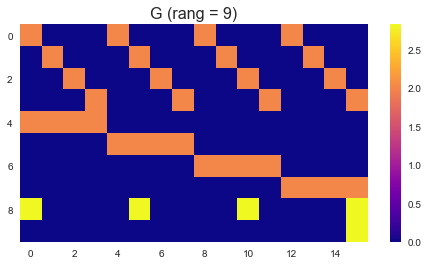

In [3]:
G = np.zeros((10, nx*nz))

G[0, ::4] = h
G[1, 1::4] = h
G[2, 2::4] = h
G[3, 3::4] = h
G[4, :4] = h
G[5, 4:8] = h
G[6, 8:12] = h
G[7, 12:16] = h
G[8, ::5] = np.sqrt(2*h*h)
G[9, -1] = np.sqrt(2*h*h)

p = np.linalg.matrix_rank(G)
N, M = G.shape

plt.figure(figsize=(8, 4))
plt.imshow(G, cmap='plasma')
plt.grid()
plt.colorbar()
plt.title('G (rang = {0:g})'.format(p), fontsize=16)
plt.show()

### SVD

On va utiliser la décompostion en valeurs singulières pour faire cette étude

In [4]:
help(np.linalg.svd)

Help on function svd in module numpy.linalg:

svd(a, full_matrices=True, compute_uv=True, hermitian=False)
    Singular Value Decomposition.
    
    When `a` is a 2D array, it is factorized as ``u @ np.diag(s) @ vh
    = (u * s) @ vh``, where `u` and `vh` are 2D unitary arrays and `s` is a 1D
    array of `a`'s singular values. When `a` is higher-dimensional, SVD is
    applied in stacked mode as explained below.
    
    Parameters
    ----------
    a : (..., M, N) array_like
        A real or complex array with ``a.ndim >= 2``.
    full_matrices : bool, optional
        If True (default), `u` and `vh` have the shapes ``(..., M, M)`` and
        ``(..., N, N)``, respectively.  Otherwise, the shapes are
        ``(..., M, K)`` and ``(..., K, N)``, respectively, where
        ``K = min(M, N)``.
    compute_uv : bool, optional
        Whether or not to compute `u` and `vh` in addition to `s`.  True
        by default.
    hermitian : bool, optional
        If True, `a` is assumed to be

### Calcul des matrices

In [5]:
dobs = G @ mtrue

U, s, Vh = np.linalg.svd(G)
V = Vh.T
S = np.diag(s)

Vp = V[:, :p]
V0 = V[:, p:]
Sp = np.diag(s[:p])
Up = U[:, :p]
U0 = U[:, p:]

Gi = Vp.dot(np.linalg.inv(Sp).dot(Up.T))

mest = Gi @ dobs
dpre = G @ mest

Rm = Vp @ Vp.T
Rd = Up @ Up.T

Examinons le modèle obtenu.

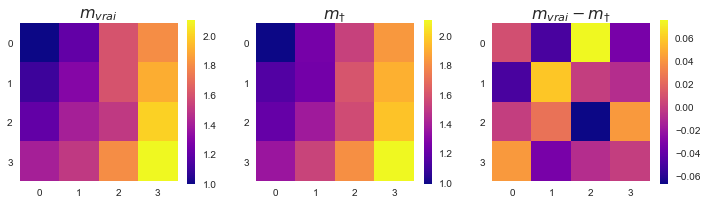

In [6]:
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.imshow(mtrue.reshape(nx, nz).T, cmap='plasma')
plt.grid()
plt.title('$m_{vrai}$', fontsize=16)
plt.colorbar()
plt.subplot(132)
plt.imshow(mest.reshape(nx, nz).T, cmap='plasma')
plt.grid()
plt.title('$m_{\dagger}$', fontsize=16)
plt.colorbar()
plt.subplot(133)
plt.imshow(mtrue.reshape(nx, nz).T - mest.reshape(nx, nz).T, cmap='plasma')
plt.grid()
plt.title('$m_{vrai} - m_{\dagger}$', fontsize=16)
plt.colorbar()
plt.show()

Est-ce que les données prédites s'ajustent bien aux données observées?

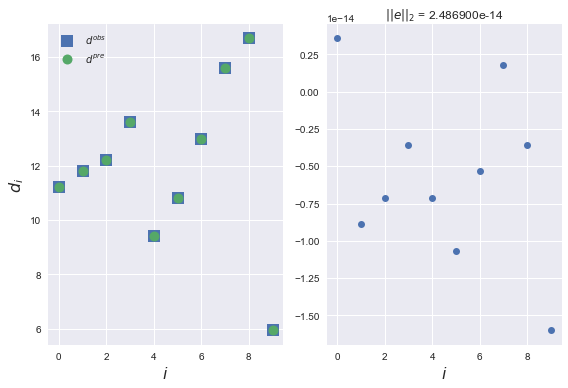

In [7]:
plt.subplot(121)
plt.plot(dobs, 's', markersize=12, label='$d^{obs}$')
plt.plot(dpre, 'o', markersize=10, label='$d^{pre}$')
plt.legend()
plt.ylabel('$d_i$', fontsize=16)
plt.xlabel('$i$', fontsize=16)

plt.subplot(122)
plt.plot(dobs-dpre, 'o')
plt.title('$\||e\||_2$ = {0:e}'.format(np.linalg.norm(dobs-dpre)))
plt.xlabel('$i$', fontsize=16)
plt.tight_layout()
plt.show()

### Affichage du spectre des valeurs singulières



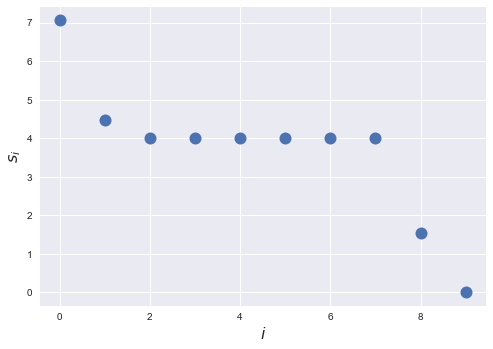

Dernière valeur singulière:  4.173298041088043e-16


In [8]:
plt.plot(s, 'o', markersize=12)
plt.ylabel('$s_i$', fontsize=16)
plt.xlabel('$i$', fontsize=16)
plt.show()

print('Dernière valeur singulière: ', s[-1])

Comme le rang $p$ vaut 9 et qu'il est inférieur à $M$ et $N$, on obtient une solution "longueur minimum".  

Examinons l'espace des paramètres.

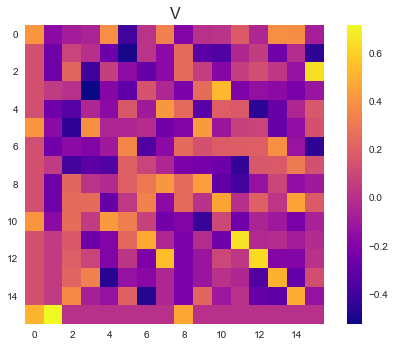

In [9]:
plt.imshow(V, cmap='plasma')
plt.grid()
plt.colorbar()
cl = plt.gci().get_clim()
plt.title('V', fontsize=16)
plt.show()

La visualisation de la matrice V ne nous renseigne pas vraiment sur le pouvoir de résolution du système.

Examinons plutôt le noyau de l'espace du modèle, soit les vecteurs de $\mathbf{V}_0$.  On peut remarquer que la somme des contributions de chaque cellule le long d'un trajet (rais horizontaux, verticaux ou long rai oblique) est égal à 0 (précision machine), ce qui signifie que la projection de n'importe vecteur de cet espace dans $\mathbf{G}$ ne change pas l'ajustement aux données.

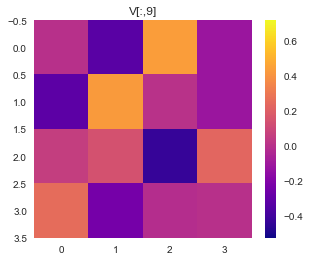

9 [[ 3.05301390e-03 -3.28246257e-01  4.40129134e-01 -1.14935891e-01]
 [-3.17618669e-01  4.28767156e-01  5.90023838e-03 -1.17048725e-01]
 [ 5.94384703e-02  1.40397084e-01 -4.31820170e-01  2.31984616e-01]
 [ 2.55127185e-01 -2.40917982e-01 -1.42092030e-02 -4.99600361e-16]]
[-3.33066907e-16 -5.55111512e-17 -9.71445147e-17  5.27355937e-16]
[ 4.16333634e-17 -1.80411242e-16 -5.27355937e-16  6.52256027e-16]
2.220446049250313e-16
[[ 8.32667268e-17]
 [-3.60822483e-16]
 [-1.05471187e-15]
 [ 1.30451205e-15]
 [-7.21644966e-16]
 [-1.11022302e-16]
 [-2.49800181e-16]
 [ 1.05471187e-15]
 [ 6.66133815e-16]
 [-1.41308321e-15]]


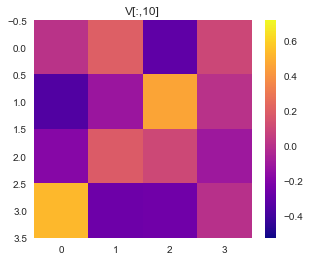

10 [[ 1.34956313e-02  1.98713064e-01 -3.09370197e-01  9.71615019e-02]
 [-3.52824669e-01 -1.16561251e-01  4.63429231e-01  5.95668903e-03]
 [-1.85064239e-01  1.85116811e-01  1.03065620e-01 -1.03118191e-01]
 [ 5.24393277e-01 -2.67268624e-01 -2.57124653e-01  2.77555756e-17]]
[ 4.44089210e-16 -3.88578059e-16 -2.22044605e-16  1.66533454e-16]
[ 2.77555756e-17  1.59594560e-16 -2.77555756e-16  8.32667268e-17]
-1.1102230246251565e-16
[[ 5.55111512e-17]
 [ 3.19189120e-16]
 [-5.55111512e-16]
 [ 1.66533454e-16]
 [ 8.88178420e-16]
 [-6.66133815e-16]
 [-4.99600361e-16]
 [ 3.19189120e-16]
 [-3.33066907e-16]
 [ 7.85046229e-17]]


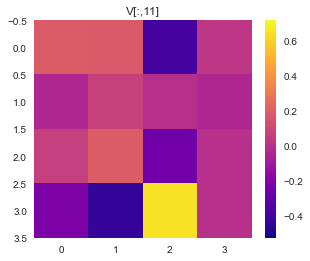

11 [[ 1.83261374e-01  1.75280742e-01 -3.91994637e-01  3.34525212e-02]
 [-3.50271388e-02  7.46829545e-02 -2.82290014e-03 -3.68329155e-02]
 [ 6.31855899e-02  1.91378344e-01 -2.57944329e-01  3.38039429e-03]
 [-2.11419825e-01 -4.41342041e-01  6.52761866e-01 -2.08166817e-17]]
[ 1.94289029e-16 -1.66533454e-16  0.00000000e+00  2.77555756e-17]
[-3.46944695e-17  1.17961196e-16  1.38777878e-17 -1.31838984e-16]
-7.632783294297951e-17
[[-6.93889390e-17]
 [ 2.35922393e-16]
 [ 2.77555756e-17]
 [-2.63677968e-16]
 [ 3.88578059e-16]
 [-3.33066907e-16]
 [-2.22044605e-16]
 [ 5.55111512e-17]
 [-2.22044605e-16]
 [-5.88784672e-17]]


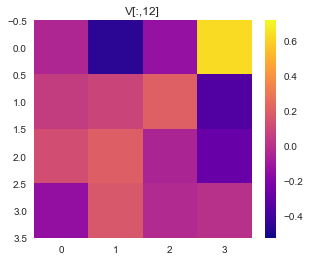

12 [[-4.12878629e-02 -4.60756035e-01 -1.32080570e-01  6.34124468e-01]
 [ 5.33172571e-02  9.06286848e-02  2.07080662e-01 -3.51026604e-01]
 [ 1.29727821e-01  2.02710865e-01 -4.93408219e-02 -2.83097864e-01]
 [-1.41757215e-01  1.67416485e-01 -2.56592704e-02  3.12250226e-17]]
[ 3.05311332e-16 -1.38777878e-16  0.00000000e+00 -3.57353036e-16]
[ 0.00000000e+00 -5.55111512e-17 -1.11022302e-16  3.46944695e-18]
8.673617379884035e-17
[[ 0.00000000e+00]
 [-1.11022302e-16]
 [-2.22044605e-16]
 [ 6.93889390e-18]
 [ 6.38378239e-16]
 [-2.22044605e-16]
 [ 0.00000000e+00]
 [-6.66133815e-16]
 [ 2.77555756e-16]
 [ 8.83177008e-17]]


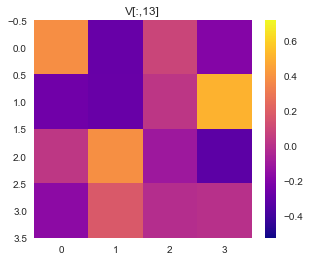

13 [[ 0.38567587 -0.283486    0.08935825 -0.19154812]
 [-0.25376588 -0.28201248  0.02660079  0.50917757]
 [ 0.03088942  0.39040342 -0.10366339 -0.31762945]
 [-0.16279941  0.17509506 -0.01229564  0.        ]]
[ 1.11022302e-16 -2.22044605e-16 -4.16333634e-17  1.11022302e-16]
[ 0.00000000e+00 -1.11022302e-16  5.55111512e-17  2.77555756e-17]
-1.3877787807814457e-17
[[ 0.00000000e+00]
 [-2.22044605e-16]
 [ 1.11022302e-16]
 [ 5.55111512e-17]
 [ 2.22044605e-16]
 [-3.33066907e-16]
 [-6.93889390e-17]
 [ 2.22044605e-16]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]


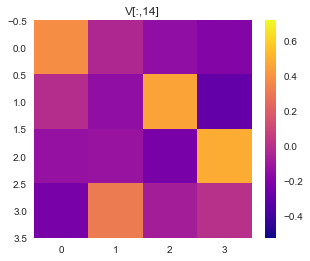

14 [[ 3.78885082e-01 -3.79223546e-02 -1.47593691e-01 -1.93369036e-01]
 [-1.30140242e-02 -1.50630562e-01  4.56182384e-01 -2.92537798e-01]
 [-1.33858149e-01 -1.23794165e-01 -2.28254520e-01  4.85906834e-01]
 [-2.32012909e-01  3.12347082e-01 -8.03341730e-02 -3.03576608e-17]]
[-1.94289029e-16  0.00000000e+00  8.32667268e-17 -8.58688121e-17]
[ 0.00000000e+00 -1.11022302e-16  1.11022302e-16 -1.69135539e-16]
-3.0357660829594124e-17
[[ 0.00000000e+00]
 [-2.22044605e-16]
 [ 2.22044605e-16]
 [-3.38271078e-16]
 [-3.88578059e-16]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-2.22044605e-16]
 [ 0.00000000e+00]
 [-8.58644313e-17]]


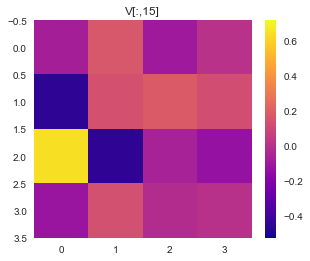

15 [[-7.45162806e-02  1.67169475e-01 -9.85015674e-02  5.84837284e-03]
 [-4.53868944e-01  1.41045476e-01  1.83025124e-01  1.29798344e-01]
 [ 6.50018776e-01 -4.47842864e-01 -6.65291958e-02 -1.35646716e-01]
 [-1.21633551e-01  1.39627912e-01 -1.79943611e-02  5.55111512e-17]]
[-1.80411242e-16  5.55111512e-17  1.17961196e-16  8.32667268e-17]
[ 4.16333634e-17  3.33066907e-16 -2.22044605e-16 -7.63278329e-17]
2.220446049250313e-16
[[ 8.32667268e-17]
 [ 6.66133815e-16]
 [-4.44089210e-16]
 [-1.52655666e-16]
 [-2.22044605e-16]
 [ 1.11022302e-16]
 [ 2.22044605e-16]
 [ 1.66533454e-16]
 [ 6.10622664e-16]
 [ 1.57009246e-16]]


In [10]:
for n in range(p, M):
    plt.figure(figsize=(5,4))
    tmp = V[:, n].reshape(nx, nz).T
    plt.imshow(tmp, cmap='plasma')
    plt.clim(cl)
    plt.grid()
    plt.colorbar()
    plt.title('V[:,{0:d}]'.format(n))
    plt.show()
    print(n, tmp)
    print(np.sum(tmp, axis=0))
    print(np.sum(tmp, axis=1))
    print(np.sum(np.diag(tmp)))
    print(G @ V[:, n].reshape(-1, 1))


À l'inverse, l'espace colonne du modèle, soit les vecteurs de $\mathbf{V}_p$, contribue à la solution.

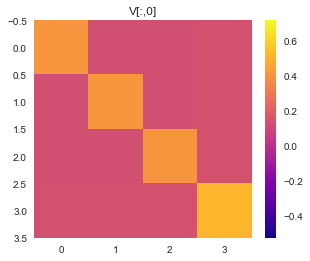

0 [[0.41306145 0.1311519  0.1311519  0.14095477]
 [0.1311519  0.41306145 0.1311519  0.14095477]
 [0.1311519  0.1311519  0.41306145 0.14095477]
 [0.14095477 0.14095477 0.14095477 0.51548647]]
[0.81632002 0.81632002 0.81632002 0.9383508 ]
[0.81632002 0.81632002 0.81632002 0.9383508 ]
1.754670819123173
[[1.63264004]
 [1.63264004]
 [1.63264004]
 [1.8767016 ]
 [1.63264004]
 [1.63264004]
 [1.63264004]
 [1.8767016 ]
 [4.96295854]
 [1.45801592]]


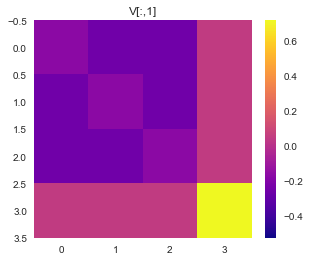

1 [[-0.16708607 -0.25449589 -0.25449589  0.04370491]
 [-0.25449589 -0.16708607 -0.25449589  0.04370491]
 [-0.25449589 -0.25449589 -0.16708607  0.04370491]
 [ 0.04370491  0.04370491  0.04370491  0.71845465]]
[-0.63237293 -0.63237293 -0.63237293  0.84956938]
[-0.63237293 -0.63237293 -0.63237293  0.84956938]
0.2171964559195585
[[-1.26474586]
 [-1.26474586]
 [-1.26474586]
 [ 1.69913877]
 [-1.26474586]
 [-1.26474586]
 [-1.26474586]
 [ 1.69913877]
 [ 0.61432435]
 [ 2.03209663]]


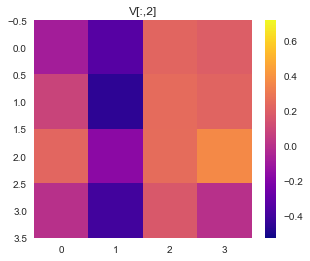

2 [[-8.02882426e-02 -3.39743925e-01  2.25032335e-01  1.94999832e-01]
 [ 8.40633534e-02 -4.54507304e-01  2.49826444e-01  2.19793940e-01]
 [ 2.29474968e-01 -1.69538201e-01  2.55680571e-01  3.65205555e-01]
 [ 3.82690074e-03 -3.95186269e-01  1.69589991e-01  2.63677968e-16]]
[ 0.23707698 -1.3589757   0.90012934  0.77999933]
[ 5.55111512e-17  9.91764336e-02  6.80822894e-01 -2.21769377e-01]
-0.2791149751774691
[[ 1.11022302e-16]
 [ 1.98352867e-01]
 [ 1.36164579e+00]
 [-4.43538754e-01]
 [ 4.74153960e-01]
 [-2.71795140e+00]
 [ 1.80025868e+00]
 [ 1.55999865e+00]
 [-7.89456367e-01]
 [ 7.45793918e-16]]


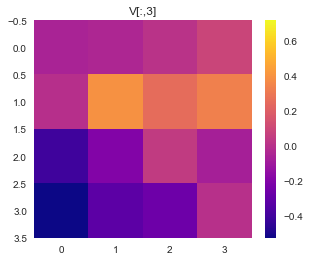

3 [[-5.84677839e-02 -4.02738066e-02  1.16001660e-02  8.71414245e-02]
 [-4.00907786e-03  3.93742027e-01  2.55837436e-01  3.31378694e-01]
 [-4.05342193e-01 -1.97369652e-01  4.42828844e-02 -6.99544206e-02]
 [-5.25166335e-01 -3.17193795e-01 -2.65319822e-01 -1.83230167e-16]]
[-0.99298539 -0.16109523  0.04640066  0.3485657 ]
[ 0.          0.97694908 -0.62838338 -1.10767995]
0.37955712704729866
[[ 0.00000000e+00]
 [ 1.95389816e+00]
 [-1.25676676e+00]
 [-2.21535990e+00]
 [-1.98597078e+00]
 [-3.22190453e-01]
 [ 9.28013282e-02]
 [ 6.97131396e-01]
 [ 1.07354967e+00]
 [-5.18253175e-16]]


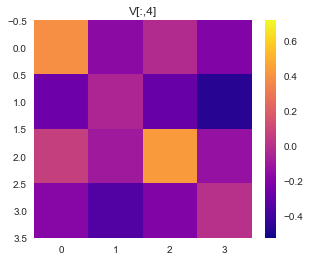

4 [[ 3.84663381e-01 -1.63739878e-01 -2.00861412e-02 -2.00837362e-01]
 [-2.65658502e-01 -4.70825155e-02 -2.86918402e-01 -4.67669623e-01]
 [ 6.71686567e-02 -9.77449792e-02  4.29398380e-01 -1.34842464e-01]
 [-1.81478502e-01 -3.46392138e-01 -2.02738402e-01  6.24500451e-16]]
[ 0.00469503 -0.65495951 -0.08034456 -0.80334945]
[-2.77555756e-17 -1.06732904e+00  2.63979593e-01 -7.30609042e-01]
0.7669792455829918
[[-5.55111512e-17]
 [-2.13465809e+00]
 [ 5.27959187e-01]
 [-1.46121808e+00]
 [ 9.39006673e-03]
 [-1.30991902e+00]
 [-1.60689130e-01]
 [-1.60669890e+00]
 [ 2.16934490e+00]
 [ 1.76635402e-15]]


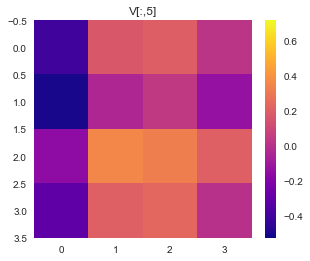

5 [[-3.98905978e-01  1.73693518e-01  2.01664445e-01  2.35480156e-02]
 [-5.01454757e-01 -4.25992251e-02  4.22436845e-02 -1.35872745e-01]
 [-1.59065220e-01  3.56662294e-01  3.27761239e-01  2.06516792e-01]
 [-3.08710030e-01  2.07017484e-01  2.34988412e-01 -2.49800181e-16]]
[-1.36813598  0.69477407  0.80665778  0.09419206]
[-2.77555756e-17 -6.37683042e-01  7.31875105e-01  1.33295866e-01]
-0.11374396437987619
[[-5.55111512e-17]
 [-1.27536608e+00]
 [ 1.46375021e+00]
 [ 2.66591733e-01]
 [-2.73627197e+00]
 [ 1.38954814e+00]
 [ 1.61331556e+00]
 [ 1.88384125e-01]
 [-3.21716514e-01]
 [-7.06541606e-16]]


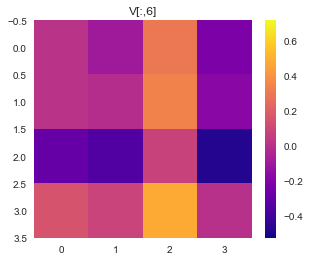

6 [[ 1.07977176e-02 -9.43330792e-02  3.01795812e-01 -2.18260450e-01]
 [ 1.24201280e-02 -1.45783577e-02  3.42484378e-01 -1.77571884e-01]
 [-2.87217454e-01 -3.53282095e-01  8.19129512e-02 -4.77209466e-01]
 [ 1.50925856e-01  8.48612152e-02  4.80990106e-01 -2.74953671e-16]]
[-0.11307375 -0.37733232  1.20718325 -0.8730418 ]
[ 2.77555756e-17  1.62754264e-01 -1.03579606e+00  7.16777178e-01]
0.07813231107744616
[[ 5.55111512e-17]
 [ 3.25508528e-01]
 [-2.07159213e+00]
 [ 1.43355436e+00]
 [-2.26147504e-01]
 [-7.54664634e-01]
 [ 2.41436649e+00]
 [-1.74608360e+00]
 [ 2.20991548e-01]
 [-7.77686421e-16]]


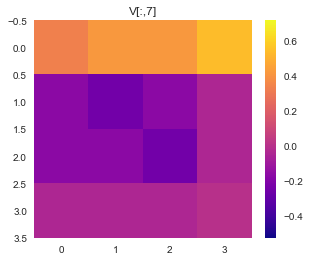

7 [[ 3.33913548e-01  4.17391936e-01  4.17391936e-01  5.42609516e-01]
 [-1.66956774e-01 -2.50435161e-01 -1.66956774e-01 -4.17391936e-02]
 [-1.66956774e-01 -1.66956774e-01 -2.50435161e-01 -4.17391936e-02]
 [-4.17391936e-02 -4.17391936e-02 -4.17391936e-02 -2.49800181e-16]]
[-0.04173919 -0.04173919 -0.04173919  0.45913113]
[ 1.71130694 -0.6260879  -0.6260879  -0.12521758]
-0.16695677422593677
[[ 3.42261387e+00]
 [-1.25217581e+00]
 [-1.25217581e+00]
 [-2.50435161e-01]
 [-8.34783871e-02]
 [-8.34783871e-02]
 [-8.34783871e-02]
 [ 9.18262258e-01]
 [-4.72225069e-01]
 [-7.06541606e-16]]


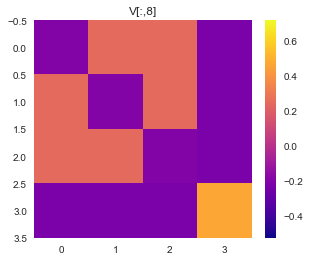

8 [[-0.19889124  0.24675528  0.24675528 -0.22282326]
 [ 0.24675528 -0.19889124  0.24675528 -0.22282326]
 [ 0.24675528  0.24675528 -0.19889124 -0.22282326]
 [-0.22282326 -0.22282326 -0.22282326  0.46700815]]
[ 0.07179606  0.07179606  0.07179606 -0.20146162]
[ 0.07179606  0.07179606  0.07179606 -0.20146162]
-0.1296655656322765
[[ 0.14359211]
 [ 0.14359211]
 [ 0.14359211]
 [-0.40292324]
 [ 0.14359211]
 [ 0.14359211]
 [ 0.14359211]
 [-0.40292324]
 [-0.3667496 ]
 [ 1.32089851]]


In [11]:
for n in range(p):
    plt.figure(figsize=(5,4))
    tmp = V[:, n].reshape(nx, nz).T
    plt.imshow(tmp, cmap='plasma')
    plt.clim(cl)
    plt.grid()
    plt.colorbar()
    plt.title('V[:,{0:d}]'.format(n))
    plt.show()
    print(n, tmp)
    print(np.sum(tmp, axis=0))
    print(np.sum(tmp, axis=1))
    print(np.sum(np.diag(tmp)))
    print(G @ V[:, n].reshape(-1, 1))

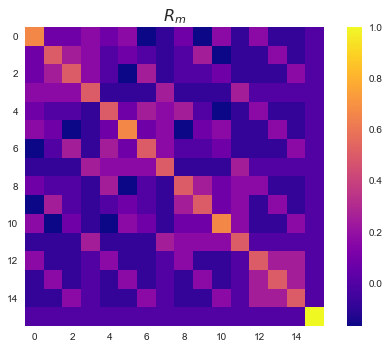

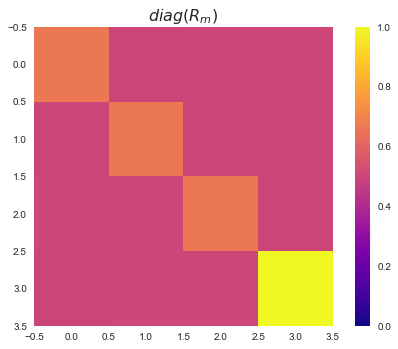

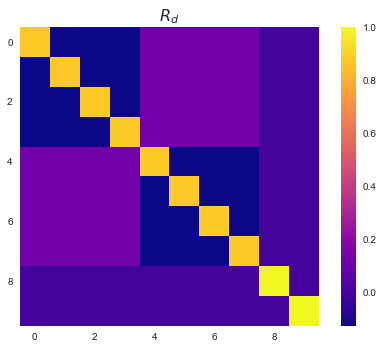

In [12]:
plt.imshow(Rm, cmap='plasma')
plt.grid()
plt.title('$R_{m}$', fontsize=16)
plt.colorbar()
plt.show()

plt.imshow(np.diag(Rm).reshape(nx, nz).T, cmap='plasma')
plt.clim(0, 1)
plt.grid()
plt.title('$diag(R_{m})$', fontsize=16)
plt.colorbar()
plt.show()

plt.imshow(Rd, cmap='plasma')
plt.grid()
plt.title('$R_{d}$', fontsize=16)
plt.colorbar()
plt.show()

Test impulsionnel

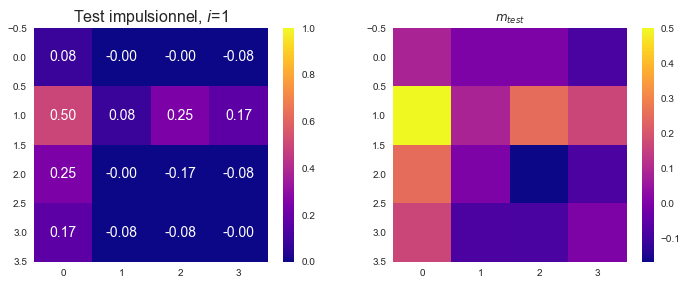

In [13]:
mi = np.zeros((nx*nz,))
mi[1] = 1

dtest = G @ mi
mtest = Gi @ dtest
res_kernel = Rm @ mi

plt.figure(figsize=(11.8, 4.3))
plt.subplot(121)
plt.imshow(res_kernel.reshape(nx, nz).T, cmap='plasma')
plt.clim(0, 1)
plt.grid()
plt.colorbar()
for i in range(nx):
    for j in range(nz):
        plt.text(i, j, '{0:3.2f}'.format(res_kernel[i*nz+j]), color='white',
                 ha='center', va='center', fontsize=14)
plt.title('Test impulsionnel, $i$=1', fontsize=16)

plt.subplot(122)
plt.imshow(mtest.reshape(nx, nz).T, cmap='plasma')
plt.grid()
plt.colorbar()
plt.title('$m_{test}$')

plt.show()

## 2e expérience

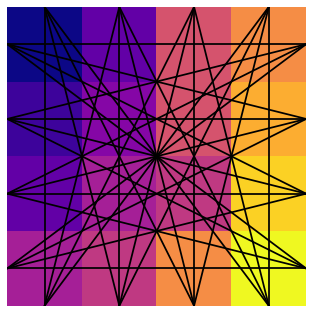

In [14]:
grx = h*np.arange(5.0)
grz = h*np.arange(5.0)

Tx = h*np.array([[0.0, 0.5], [0.0, 0.5], [0.0, 0.5], [0.0, 0.5],
                 [0.0, 1.5], [0.0, 1.5], [0.0, 1.5], [0.0, 1.5],
                 [0.0, 2.5], [0.0, 2.5], [0.0, 2.5], [0.0, 2.5],
                 [0.0, 3.5], [0.0, 3.5], [0.0, 3.5], [0.0, 3.5],
                 [0.5, 0.0], [0.5, 0.0], [0.5, 0.0], [0.5, 0.0],
                 [1.5, 0.0], [1.5, 0.0], [1.5, 0.0], [1.5, 0.0],
                 [2.5, 0.0], [2.5, 0.0], [2.5, 0.0], [2.5, 0.0],
                 [3.5, 0.0], [3.5, 0.0], [3.5, 0.0], [3.5, 0.0]])

Rx = h*np.array([[4.0, 0.5], [4.0, 1.5], [4.0, 2.5], [4.0, 3.5],
                 [4.0, 0.5], [4.0, 1.5], [4.0, 2.5], [4.0, 3.5],
                 [4.0, 0.5], [4.0, 1.5], [4.0, 2.5], [4.0, 3.5],
                 [4.0, 0.5], [4.0, 1.5], [4.0, 2.5], [4.0, 3.5],
                 [0.5, 4.0], [1.5, 4.0], [2.5, 4.0], [3.5, 4.0],
                 [0.5, 4.0], [1.5, 4.0], [2.5, 4.0], [3.5, 4.0],
                 [0.5, 4.0], [1.5, 4.0], [2.5, 4.0], [3.5, 4.0],
                 [0.5, 4.0], [1.5, 4.0], [2.5, 4.0], [3.5, 4.0]])

Tx2 = Tx/h-0.5
Rx2 = Rx/h-0.5

plt.imshow(mtrue.reshape(nx, nz).T, cmap='plasma')
plt.grid()
for n in range(Tx2.shape[0]):
    plt.plot((Tx2[n, 0], Rx2[n, 0]), (Tx2[n, 1], Rx2[n, 1]), '-k')
plt.gca().set_xticklabels('')
plt.gca().set_yticklabels('')
plt.show()

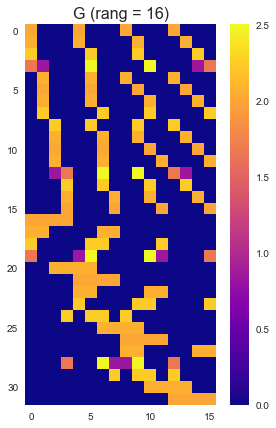

In [15]:
G = Grid2d.data_kernel_straight_rays(Tx, Rx, grx, grz).toarray()

p = np.linalg.matrix_rank(G)
N, M = G.shape

plt.figure(figsize=(5, 7))
plt.imshow(G, cmap='plasma')
plt.grid()
plt.colorbar()
plt.title('G (rang = {0:g})'.format(p), fontsize=16)
plt.show()

Calcul des matrices et de la solution.

In [16]:
dobs = G @ mtrue

U, s, Vh = np.linalg.svd(G)
V = Vh.T
S = np.diag(s)

Vp = V[:, :p]
V0 = V[:, p:]
Sp = np.diag(s[:p])
Up = U[:, :p]
U0 = U[:, p:]

Gi = Vp.dot(np.linalg.inv(Sp).dot(Up.T))

mest = Gi @ dobs
dpre = G @ mest

Rm = Vp @ Vp.T
Rd = Up @ Up.T

Spectre des valeurs singulières

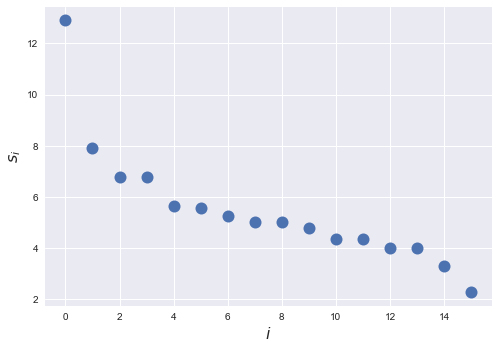

In [17]:
plt.plot(s, 'o', markersize=12)
plt.ylabel('$s_i$', fontsize=16)
plt.xlabel('$i$', fontsize=16)
plt.show()

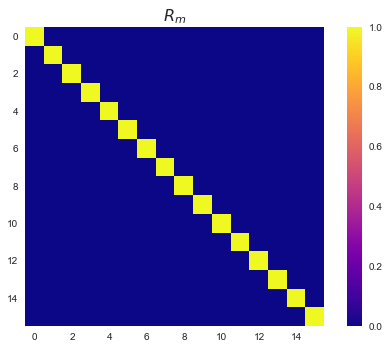

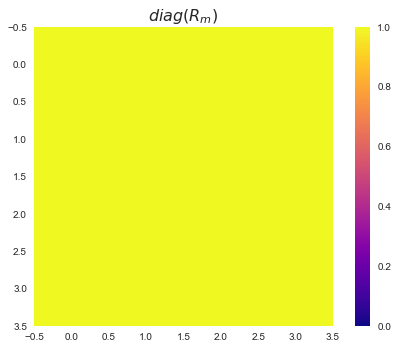

In [18]:
plt.imshow(Rm, cmap='plasma')
plt.grid()
plt.title('$R_{m}$', fontsize=16)
plt.colorbar()
plt.show()

plt.imshow(np.diag(Rm).reshape(nx, nz).T, cmap='plasma')
plt.clim(0, 1)
plt.grid()
plt.title('$diag(R_{m})$', fontsize=16)
plt.colorbar()
plt.show()


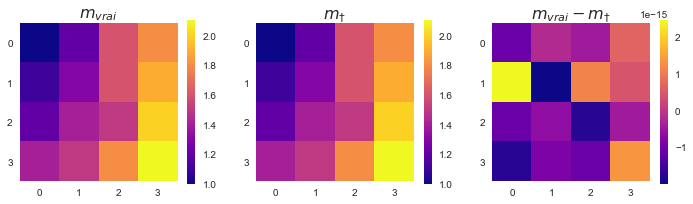

In [19]:
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.imshow(mtrue.reshape(nx, nz).T, cmap='plasma')
plt.grid()
plt.title('$m_{vrai}$', fontsize=16)
plt.colorbar()
plt.subplot(132)
plt.imshow(mest.reshape(nx, nz).T, cmap='plasma')
plt.grid()
plt.title('$m_{\dagger}$', fontsize=16)
plt.colorbar()
plt.subplot(133)
plt.imshow(mtrue.reshape(nx, nz).T - mest.reshape(nx, nz).T, cmap='plasma')
plt.grid()
plt.title('$m_{vrai} - m_{\dagger}$', fontsize=16)
plt.colorbar()
plt.show()

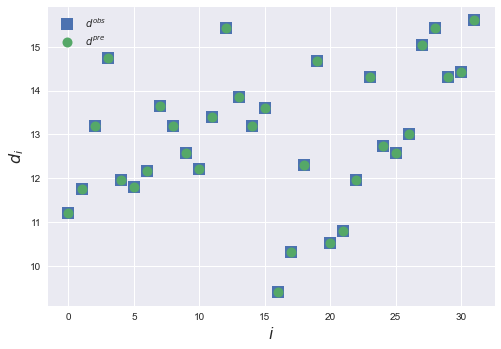

In [20]:
plt.plot(dobs, 's', markersize=12, label='$d^{obs}$')
plt.plot(dpre, 'o', markersize=10, label='$d^{pre}$')
plt.legend()
plt.ylabel('$d_i$', fontsize=16)
plt.xlabel('$i$', fontsize=16)
plt.show()

## Influence du bruit

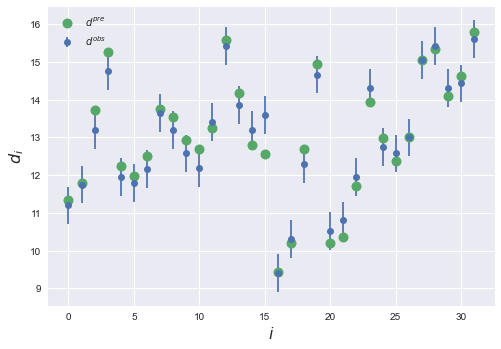

In [21]:
sd = 0.5
bruit = sd*np.random.randn(dobs.size)
dobs_b = dobs + bruit

mest = Gi @ dobs_b
dpre = G @ mest

plt.errorbar(np.arange(dobs.size), dobs, yerr=sd, fmt='o',
             label='$d^{obs}$')
plt.plot(dpre, 'o', markersize=10, label='$d^{pre}$')
plt.legend()
plt.ylabel('$d_i$', fontsize=16)
plt.xlabel('$i$', fontsize=16)
plt.show()

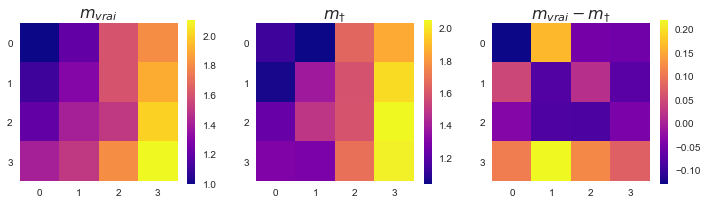

In [22]:
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.imshow(mtrue.reshape(nx, nz).T, cmap='plasma')
plt.grid()
plt.title('$m_{vrai}$', fontsize=16)
plt.colorbar()
plt.subplot(132)
plt.imshow(mest.reshape(nx, nz).T, cmap='plasma')
plt.grid()
plt.title('$m_{\dagger}$', fontsize=16)
plt.colorbar()
plt.subplot(133)
plt.imshow(mtrue.reshape(nx, nz).T - mest.reshape(nx, nz).T, cmap='plasma')
plt.grid()
plt.title('$m_{vrai} - m_{\dagger}$', fontsize=16)
plt.colorbar()
plt.show()

Le bruit dans les mesure entraîne inévitablement une erreur dans l'estimation des paramètres, même si la résolution est "parfaite".